# About the data

- Data represents scores or measurements from sensors in SMC manufacturing
- Useful info mixed with irrelevant and noisy data.
- Supervised data: X: features
                   Y: -1(Pass)/+1(Fail)
- Task: Pass/Fail classifcation. Rank features according to their impact on the manufacturing yield
- Provided baseline results with kernel ridge classifier and 10-fold cross validation
- Feature relevance for task prediction
- Feature plotting: https://bigml.com/user/czuriaga/gallery/dataset/525c71d4035d076e7f004c77

TO explore:
- Identify anomalies in rows
- More ways to tackle imbalanced classification, and better non-linear classifiers
- Clustering features to observe confusion matrix

In [1]:
import pandas

prefix = ""
X_path = f"{prefix}secom.data"
Y_path = f"{prefix}secom_labels.data"

X_df = pandas.read_csv(X_path, delimiter=" ", header=None)
Y_df = pandas.read_csv(Y_path, delimiter=" ", header=None)
#print(X_df.info())
#print(Y_df.info())

In [2]:
X_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,0.003400,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,0.004700,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,0.006475,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,0.028600,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


### Observations
- Incosistent number of observations per day
- Missing data for atleast 1 feature in every row of the data
- 52/590 cols in X_df have valid values (X_df.dropna(axis=1))
- From describe log, some of cols have 0 std. Implies that feature is constant across observations.


## Data Wrangling

In [3]:
# Removing cols where >250 vals are missing for a sensor feat. col.
print('Dropping cols. with more missing values: ', X_df.columns.where(X_df.isna().sum()>250).dropna().values)
X_df = X_df.drop(columns = X_df.columns.where(X_df.isna().sum()>250).dropna())
print('New dataframe shape: ', X_df.shape)

# fill missing values with interpolation for rows 1:N and backfill for row 0
cX_df = X_df.interpolate()
cX_df = cX_df.fillna(method='bfill')
assert cX_df.isna().any().any()==False, "Some NaN values in df!!"

# removing cols with constant values
print('Cols with constant values', (cX_df.loc[:, cX_df.std()==0.0]).columns.values)
dX_df = cX_df.loc[:, cX_df.std()>0.0]
print('\nNew DF shape: ', dX_df.shape)

Dropping cols. with more missing values:  [ 72.  73.  85. 109. 110. 111. 112. 157. 158. 220. 244. 245. 246. 247.
 292. 293. 345. 346. 358. 382. 383. 384. 385. 492. 516. 517. 518. 519.
 546. 547. 548. 549. 550. 551. 552. 553. 554. 555. 556. 557. 562. 563.
 564. 565. 566. 567. 568. 569. 578. 579. 580. 581.]
New dataframe shape:  (1567, 538)
Cols with constant values [  5  13  42  49  52  69  97 141 149 178 179 186 189 190 191 192 193 194
 226 229 230 231 232 233 234 235 236 237 240 241 242 243 256 257 258 259
 260 261 262 263 264 265 266 276 284 313 314 315 322 325 326 327 328 329
 330 364 369 370 371 372 373 374 375 378 379 380 381 394 395 396 397 398
 399 400 401 402 403 404 414 422 449 450 451 458 461 462 463 464 465 466
 481 498 501 502 503 504 505 506 507 508 509 512 513 514 515 528 529 530
 531 532 533 534 535 536 537 538]

New DF shape:  (1567, 422)


<hr>

## Classification with all features

- Use oversampling and undersampling to overcome less failed observations
- Tried SVC, RidgeClassifier for classification 

#### Observations
- Undersampling 'Pass(-1)' class cases gives better accuracy.
- Although accuracy is high for SVC, BER is better for simple ridge classifier with cross validation.
- BER is better measure to understand the performance for this task.

In [23]:
# 422 valid features with 1567 samples
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

X = dX_df.to_numpy()
print('Feat. mat shape: ', X.shape)

# y = Y_df[0].replace(-1, 0).to_numpy()
y = Y_df[0].to_numpy()
print('Y mat shape: ', y.shape)
print('No. of fails: ', np.count_nonzero(y==1))
print('No. of pass: ', np.count_nonzero(y==-1))

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=0)

# oversampling fail cases in train split only
sampler = RandomUnderSampler(sampling_strategy=0.15)
# sampler = RandomOverSampler(sampling_strategy=0.5)
X_train1, y_train1 = sampler.fit_resample(X_train, y_train)
print('Pass vs Fail count in train set', np.count_nonzero(y_train1==-1), np.count_nonzero(y_train1==1))

print('\n Training and fitting classifier.....\n')
clf = RidgeClassifierCV(cv=10, class_weight='balanced')
# clf = SVC(kernel='linear')
clf.fit(X_train1, y_train1)
print('Acc: ', clf.score(X_test, y_test)*100)

preds = clf.predict(X_test)
ber = 1-balanced_accuracy_score(y_test, preds)
print(f'BER: {ber*100} %')

cm = confusion_matrix(y_test, preds)
print(cm)
print(f'No of fails identified: {cm[1, 1]}/{np.count_nonzero(y_test==1)}')
print(f'No. of pass identified: {cm[0, 0]}/{np.count_nonzero(y_test==-1)}')

Feat. mat shape:  (1567, 422)
Y mat shape:  (1567,)
No. of fails:  104
No. of pass:  1463
Pass vs Fail count in train set 506 76

 Training and fitting classifier.....

Acc:  79.92277992277992
BER: 35.86734693877551 %
[[401  89]
 [ 15  13]]
No of fails identified: 13/28
No. of pass identified: 401/490


<hr>

## Feature Selection and classification

- Using supervised feature selection method to identify top_K features for classification.
- Simple univariate feature selection using mutual information.
- Same classification scenario as above with top_K features
- For <strong>100/422</strong> features, we observe best performance.
- BER for this selection is: <strong>~33 %</strong> (Lower than the all features results reported above)


Feat. mat shape:  (1567, 422)
Y mat shape:  (1567,)
No. of fails:  104
No. of pass:  1463
Pass vs Fail count in train set 506 76

 Features picked for classification:  (array([  5,  11,  26,  30,  33,  35,  36,  39,  45,  50,  51,  52,  53,
        54,  57,  58,  59,  60,  62,  64,  70,  71,  75,  76,  93, 101,
       105, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120,
       123, 148, 152, 154, 155, 156, 157, 159, 168, 178, 190, 207, 211,
       212, 216, 217, 218, 219, 234, 244, 246, 247, 248, 251, 260, 263,
       270, 271, 275, 287, 296, 300, 304, 305, 307, 311, 312, 313, 314,
       323, 338, 341, 344, 345, 346, 364, 375, 379, 382, 392, 396, 397,
       399, 401, 406, 407, 409, 410, 413, 418, 419]),)

 Classification accuracy after univariate feature selection: 0.741
BER: 33.87755102040817 %
[[368 122]
 [ 12  16]]
No of fails identified: 16/28
No. of pass identified: 368/490


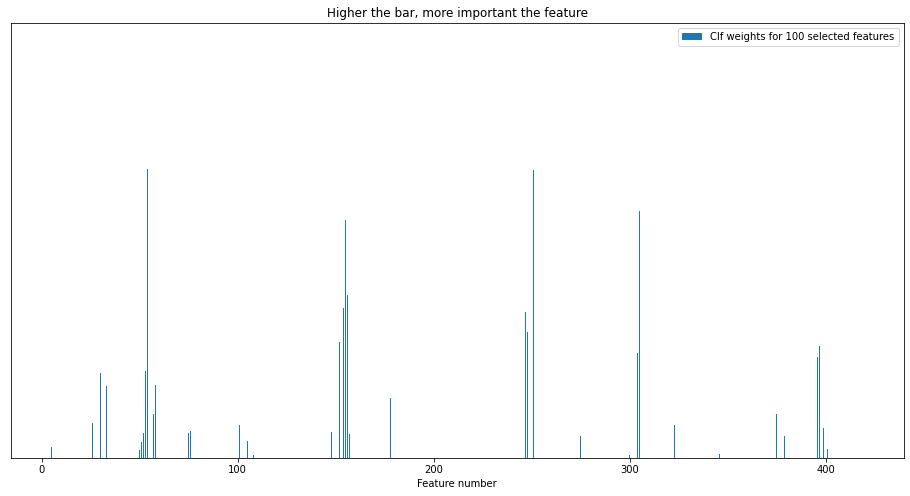

In [59]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier

X = dX_df.to_numpy()
print('Feat. mat shape: ', X.shape)

# y = Y_df[0].replace(-1, 0).to_numpy()
y = Y_df[0].to_numpy()
print('Y mat shape: ', y.shape)
print('No. of fails: ', np.count_nonzero(y==1))
print('No. of pass: ', np.count_nonzero(y==-1))

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=0)

# oversampling fail cases in train split only
sampler = RandomUnderSampler(sampling_strategy=0.15)
# sampler = RandomOverSampler(sampling_strategy=0.5)
X_train1, y_train1 = sampler.fit_resample(X_train, y_train)
print('Pass vs Fail count in train set', np.count_nonzero(y_train1==-1), np.count_nonzero(y_train1==1))

topK = 100
clf = RidgeClassifierCV(cv=10, class_weight='balanced')
selector = SelectKBest(mutual_info_classif, k=topK)
selector.fit(X_train1, y_train1)
X_train1_topK = selector.transform(X_train1)
X_test_topK = selector.transform(X_test)

clf.fit(X_train1_topK, y_train1)
print('\n Features picked for classification: ', np.where(selector.get_support()==True))
print('\n Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf.score(X_test_topK, y_test)))

preds = clf.predict(X_test_topK)
ber = 1-balanced_accuracy_score(y_test, preds)
print(f'BER: {ber*100} %')

cm = confusion_matrix(y_test, preds)
print(cm)
print(f'No of fails identified: {cm[1, 1]}/{np.count_nonzero(y_test==1)}')
print(f'No. of pass identified: {cm[0, 0]}/{np.count_nonzero(y_test==-1)}')

X_indices = np.arange(X_scaled.shape[-1])
weights_selected = np.abs(clf.coef_).sum(axis=0)
weights_selected /= weights_selected.sum()
_ = plt.figure(figsize=(16, 8))
plt.bar(X_indices[selector.get_support()] - .05, weights_selected,
        width=.2, label='Clf weights for 100 selected features')


plt.title("Higher the bar, more important the feature")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

<hr>

## Analysis and Graphs

- Here, we experiment with different number of features to identify the optimum number of features required for classification.
- For K=100, we obeserve best pass and fail accuracy along with small BER

Feat. mat shape:  (1567, 422)
Y mat shape:  (1567,)
No. of fails:  104
No. of pass:  1463
Pass vs Fail count in train set 506 76


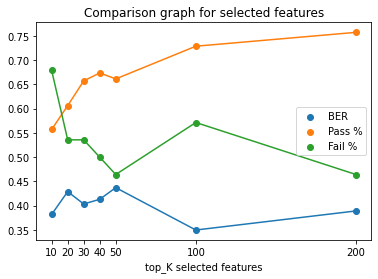

In [60]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier

def classify(X_train, y_train, X_test, y_test, topK):
        clf = RidgeClassifierCV(cv=10, class_weight='balanced')
        selector = SelectKBest(mutual_info_classif, k=topK)
        selector.fit(X_train, y_train)
        X_train_topK = selector.transform(X_train)
        X_test_topK = selector.transform(X_test)

        clf.fit(X_train_topK, y_train)
        preds = clf.predict(X_test_topK)
        ber = 1-balanced_accuracy_score(y_test, preds)
#         print(f'BER: {ber*100} %')

        cm = confusion_matrix(y_test, preds)
        fail_acc = cm[1, 1]/np.count_nonzero(y_test==1)
        pass_acc = cm[0, 0]/np.count_nonzero(y_test==-1)
        return ber, fail_acc, pass_acc                     
        
X = dX_df.to_numpy()
print('Feat. mat shape: ', X.shape)

# y = Y_df[0].replace(-1, 0).to_numpy()
y = Y_df[0].to_numpy()
print('Y mat shape: ', y.shape)
print('No. of fails: ', np.count_nonzero(y==1))
print('No. of pass: ', np.count_nonzero(y==-1))

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=0)

# oversampling fail cases in train split only
sampler = RandomUnderSampler(sampling_strategy=0.15)
# sampler = RandomOverSampler(sampling_strategy=0.5)
X_train1, y_train1 = sampler.fit_resample(X_train, y_train)
print('Pass vs Fail count in train set', np.count_nonzero(y_train1==-1), np.count_nonzero(y_train1==1))

bers = []
pass_accs = []
fail_accs = []
Ks = [10, 20, 30, 40, 50, 100, 200]
for topK in Ks:
    ber, fail_acc, pass_acc = classify(X_train1, y_train1, X_test, y_test, topK)
    bers.append(ber)
    pass_accs.append(pass_acc)
    fail_accs.append(fail_acc)


plt.plot(Ks, bers)
plt.plot(Ks, pass_accs)
plt.plot(Ks, fail_accs)
plt.scatter(Ks, bers, label='BER')
plt.scatter(Ks, pass_accs, label='Pass %')
plt.scatter(Ks, fail_accs, label='Fail %')
plt.title("Comparison graph for selected features")
plt.xlabel('top_K selected features')
plt.xticks(Ks)
plt.legend()
plt.show()
                             
